# IMPORT LIBRARIES

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    os.mkdir('./semua-gunung')
    os.mkdir('./semua-gunung/training')
    os.mkdir('./semua-gunung/testing')
except OSError:
    pass

list_iter = ["training","testing"]
list_gunung = os.listdir("./Gunung/")

for i in list_iter:
    for j in list_gunung:
        try:
            os.mkdir("./semua-gunung/"+i+"/"+j)
        except OSError:
            pass


In [3]:
def get_path(nama_gunung):
    source = "./Gunung/" + nama_gunung + "/"
    train_dest = "./semua-gunung/training/" + nama_gunung + "/"
    test_dest = "./semua-gunung/testing/" + nama_gunung + "/"
    
    return source,train_dest,test_dest

In [4]:
def splitting(source, training, testing, split_size):
    list_file = []
    for _ in os.listdir(source):
        file = source + _
        if os.path.getsize(file) > 0:
            list_file.append(_)

    training_length = int(len(list_file) * split_size)
    testing_length = int(len(list_file) - training_length)
    shuffled_set = random.sample(list_file, len(list_file))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = source + filename
        destination = testing + filename
        copyfile(this_file, destination)
        
rinjani_source, training_rinjani_dest, testing_rinjani_dest = get_path("Gunung Rinjani")
tangkuban_source, training_tangkuban_dest, testing_tangkuban_dest = get_path("Gunung Tangkuban Perahu")
bromo_source, training_bromo_dest, testing_bromo_dest = get_path("Gunung Bromo")
ijen_source, training_ijen_dest, testing_ijen_dest = get_path("Gunung Ijen")
papandayan_source, training_papandayan_dest, testing_papandayan_dest = get_path("Gunung Papandayan")


split_size = 0.9
splitting(rinjani_source,training_rinjani_dest,testing_rinjani_dest,split_size)
splitting(tangkuban_source,training_tangkuban_dest,testing_tangkuban_dest,split_size)
splitting(bromo_source,training_bromo_dest,testing_bromo_dest,split_size)
splitting(ijen_source,training_ijen_dest,testing_ijen_dest,split_size)
splitting(papandayan_source,training_papandayan_dest,testing_papandayan_dest,split_size)

In [5]:
os.listdir('./Gunung/Gunung Rinjani/')[:5]

['rinjani_1.jpg',
 'rinjani_10.jpg',
 'rinjani_11.jpg',
 'rinjani_12.jpg',
 'rinjani_13.jpg']

# DEFINING CALLBACKS

In [6]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/10))

In [88]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.84):
            print("\nReached 84% accuracy so training done!")
            self.model.stop_training = True

callbacks = myCallback()

In [89]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only= True)

# MODEL BUILDING

In [90]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=RMSprop(learning_rate=5e-04), loss='categorical_crossentropy', metrics=['acc'])

In [91]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [92]:
TRAINING_DIR = "./semua-gunung/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=15,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

VALIDATION_DIR = "./semua-gunung/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=15,
                                                              class_mode='categorical',
                                                              target_size=(300, 300))

TESTING_DIR = "./testing/"
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                        class_mode='categorical',
                                                        target_size=(300,300))



Found 269 images belonging to 5 classes.
Found 31 images belonging to 5 classes.
Found 14 images belonging to 5 classes.


In [93]:
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [callbacks])

Epoch 1/30
18/18 [==============================] - 21s 1s/step - loss: 1.6508 - acc: 0.2119 - val_loss: 1.5740 - val_acc: 0.3226
Epoch 2/30
18/18 [==============================] - 18s 1s/step - loss: 1.4852 - acc: 0.3532 - val_loss: 1.2957 - val_acc: 0.4839
Epoch 3/30
18/18 [==============================] - 18s 1s/step - loss: 1.3106 - acc: 0.4387 - val_loss: 1.1131 - val_acc: 0.5161
Epoch 4/30
18/18 [==============================] - 18s 998ms/step - loss: 1.2470 - acc: 0.4796 - val_loss: 1.0225 - val_acc: 0.6129
Epoch 5/30
18/18 [==============================] - 18s 1s/step - loss: 1.0891 - acc: 0.5725 - val_loss: 1.1821 - val_acc: 0.5484
Epoch 6/30
18/18 [==============================] - 18s 993ms/step - loss: 1.0234 - acc: 0.6283 - val_loss: 0.9231 - val_acc: 0.6774
Epoch 7/30
18/18 [==============================] - 18s 997ms/step - loss: 0.9102 - acc: 0.6431 - val_loss: 0.9793 - val_acc: 0.5806
Epoch 8/30
18/18 [==============================] - 18s 1s/step - loss: 1.0344 - 

<Figure size 432x288 with 0 Axes>

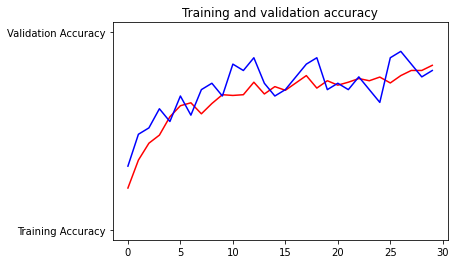

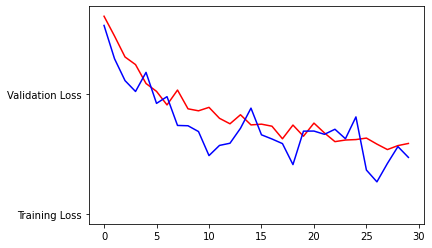

<Figure size 432x288 with 0 Axes>

In [94]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [95]:
label_map = train_generator.class_indices
label_map = {y: x for x, y in label_map.items()}

In [103]:
scores = model.evaluate(testing_generator,verbose=1)

1/1 [==============================] - 0s 263ms/step - loss: 0.4754 - acc: 0.7857


In [97]:
prediction = model.predict(testing_generator)

In [98]:
for i in range(14):
    print(label_map[np.argmax(prediction[i])],np.argmax(prediction[i])==testing_generator.labels[i])

Gunung Papandayan False
Gunung Ijen False
Gunung Bromo True
Gunung Papandayan False
Gunung Papandayan False
Gunung Bromo False
Gunung Tangkuban Perahu False
Gunung Rinjani False
Gunung Bromo False
Gunung Bromo False
Gunung Papandayan False
Gunung Rinjani True
Gunung Rinjani False
Gunung Tangkuban Perahu True


# TESTING EVALUATION

In [99]:
current = os.getcwd()
from keras.preprocessing import image
import cv2
import numpy as np

img_path = os.path.join(current,"testing_copy\\")
images = os.listdir(img_path)
label_map = train_generator.class_indices
label_map = {y: x for x, y in label_map.items()}

for i in images:
    print()
    path = './testing_copy/' + i
    img = image.load_img(path, target_size=(300,300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    prediction = model.predict(images)
    
    print(path)
    print(np.argsort(prediction)[::-1])
    print(label_map[np.argmax(prediction)])


./testing_copy/bromo_1.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/bromo_2.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/bromo_3.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/bromo_4.jpg
[[1 3 4 0 2]]
Gunung Papandayan

./testing_copy/ijen_1.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/ijen_2.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/ijen_3.jpg
[[0 2 3 4 1]]
Gunung Ijen

./testing_copy/papandayan_1.jpg
[[0 1 3 4 2]]
Gunung Papandayan

./testing_copy/papandayan_2.jpg
[[0 1 3 4 2]]
Gunung Papandayan

./testing_copy/papandayan_3.jpg
[[0 1 3 4 2]]
Gunung Papandayan

./testing_copy/rinjani_1.jpg
[[0 1 2 4 3]]
Gunung Rinjani

./testing_copy/rinjani_2.jpg
[[0 1 3 4 2]]
Gunung Papandayan

./testing_copy/tangkuban_1.jpg
[[0 1 2 3 4]]
Gunung Tangkuban Perahu

./testing_copy/tangkuban_2.jpg
[[0 1 2 3 4]]
Gunung Tangkuban Perahu


In [19]:
train_generator.class_indices

{'Gunung Bromo': 0,
 'Gunung Ijen': 1,
 'Gunung Papandayan': 2,
 'Gunung Prau': 3,
 'Gunung Rinjani': 4,
 'Gunung Tangkuban Perahu': 5}

# SAVING MODEL AND CONVERT TO TFLITE

In [100]:
model.save("klasifikasi_gunung_2.h5")

In [101]:
model_gunung = tf.keras.models.load_model('klasifikasi_gunung_2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_gunung)
tflite_model = converter.convert()
open("converted_model_gunung_2.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy964_l99\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy964_l99\assets


8670080

In [87]:
tf.keras.backend.clear_session()

# RUN MODEL

In [ ]:
import numpy as np
import tensorflow as tf

In [136]:
model_gunung = tf.keras.models.load_model('klasifikasi_gunung_better_83%.h5')

In [8]:
path = './testing/rinjani_2.jpg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(300, 300))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
    
images = np.vstack([x])
prediction = model_gunung.predict(images)

model_gunung.predict(images)

array([[0., 0., 1., 0., 0., 0.]], dtype=float32)